# Variational problems

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/JuliaOptimalTransport/OptimalTransport.jl/blob/master/examples/variational/script.jl).
The rendered HTML can be viewed [in the docs](https://juliaoptimaltransport.github.io/OptimalTransport.jl/dev/examples/variational/).*

In this example, we will numerically simulate an entropy-regularised Wasserstein gradient flow
approximating the Fokker-Planck and porous medium equations.

The connection between Wasserstein gradient flows and (non)-linear PDEs is due to Jordan, Kinderlehrer and Otto [^JKO98], and
an easy-to-read overview of the topic is provided in Section 9.3 [^PC19]

[^JKO98]: Jordan, Richard, David Kinderlehrer, and Felix Otto. "The variational formulation of the Fokker--Planck equation." SIAM journal on mathematical analysis 29.1 (1998): 1-17.
[^PC19]: Peyré, Gabriel, and Marco Cuturi. "Computational optimal transport: With applications to data science." Foundations and Trends® in Machine Learning 11.5-6 (2019): 355-607.

## Fokker-Planck equation as a $W_2$ gradient flow
For a potential function $\Psi$ and noise level $\sigma^2$, the Fokker-Planck equation (FPE) is
$$
\partial_t \rho_t = \nabla \cdot (\rho_t \nabla \Psi) + \frac{\sigma^2}{2} \Delta \rho_t,
$$
and we take no-flux (Neumann) boundary conditions.

This describes the evolution of a massless particle undergoing both diffusion (with diffusivity $\sigma^2$) and drift (along potential $\Psi$) according to the stochastic differential equation
$$
dX_t = -\nabla \Psi(X_t) dt + \sigma dB_t.
$$
The result of Jordan, Kinderlehrer and Otto (commonly referred to as the JKO theorem) states that
$\rho_t$ evolves following the 2-Wasserstein gradient flow of the Gibbs free energy functional
$$
  F(\rho) = \int \Psi d\rho + \int \log(\rho) d\rho.
$$

## Implicit schemes for gradient flows
In an Euclidean space, the gradient flow of a functional $F$ is simply the solution of an ordinary differential equation
$$
 \dfrac{dx(t)}{dt} = -\nabla F(x(t)).
$$
Of course, there is a requirement that $F$ is smooth. A more general formulation of a gradient flow that allows
$F$ to be non-smooth is the implicit scheme
$$
  x_{t+\tau} = \operatorname{argmin}_x \frac{1}{2} \| x - x_t \|_2^2 + \tau F(x).
$$
As the timestep $\tau$ shrinks, $x_t$ becomes a better and better approximation to the gradient flow of $F$.

## Wasserstein gradient flow
In the context of the JKO theorem, we seek $\rho_t$ that is the gradient flow of $F$ with
respect to the 2-Wasserstein distance. This can be achieved by choosing the $W_2$ metric in the implicit step:
$$
  \rho_{t + \tau} = \operatorname{argmin}_{\rho} d_{W_2}^2(\rho_{t}, \rho) + \tau F(\rho).
$$
Finally, a numerical scheme for computing this gradient flow can be developed by using the entropic regularisation
of optimal transport on a discretised domain
$$
  \rho_{t + \tau} = \operatorname{argmin}_{\rho} \operatorname{OT}_\varepsilon(\rho_{t}, \rho) + \tau F(\rho),
$$
where
$$
  \operatorname{OT}_\varepsilon(\alpha, \beta) = \min_{\gamma \in \Pi(\alpha, \beta)} \sum_{i,j} \frac{1}{2} \| x_i - x_j \|_2^2 \gamma_{ij} + \varepsilon \sum_{i, j} \gamma_{ij} \log(\gamma_{ij}).
$$
Each step of this problem is a minimisation problem with respect to $\rho$.
Since we use entropic optimal transport which is differentiable, this can be solved using gradient-based methods.

## Problem setup

In [1]:
using OptimalTransport
using Distances
using LogExpFunctions
using Optim
using Plots
using StatsBase
using ReverseDiff

using LinearAlgebra
using Logging

Here, we set up the computational domain that we work on - we discretize the interval $[-1, 1]$.
The natural boundary conditions to use will be Neumann (zero flux), see e.g. [^Santam2017]

[^Santam2017]: Santambrogio, Filippo. "{Euclidean, metric, and Wasserstein} gradient flows: an overview." Bulletin of Mathematical Sciences 7.1 (2017): 87-154.

In [2]:
support = range(-1, 1; length=64)
C = pairwise(SqEuclidean(), support');

Now we set up various functionals that we will use.

We define the generalised entropy (Equation (4.4) of [^Peyre2015]) as follows. For $m = 1$ this is just the "regular" entropy, and $m = 2$ this is squared $L_2$.

[^Peyre2015]: Peyré, Gabriel. "Entropic approximation of Wasserstein gradient flows." SIAM Journal on Imaging Sciences 8.4 (2015): 2323-2351.

In [3]:
function E(ρ; m=1)
    if m == 1
        return sum(xlogx.(ρ)) - sum(ρ)
    elseif m > 1
        return dot(ρ, @. (ρ^(m - 1) - m) / (m - 1))
    end
end;

Now define $\psi(x)$ to be a potential energy function that has two potential wells at $x = ± 0.5$.

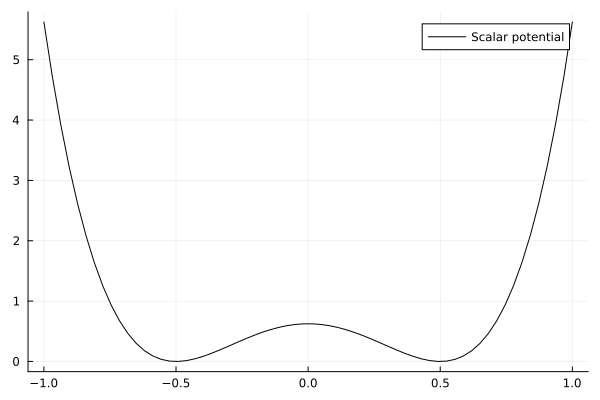

In [4]:
ψ(x) = 10 * (x - 0.5)^2 * (x + 0.5)^2;
plot(support, ψ.(support); color="black", label="Scalar potential")

Having defined $\psi$, this induces a potential energy functional $\Psi$ on probability distributions $\rho$:
$$
   \Psi(\rho) = \int \psi(x) \rho(x) dx = \langle \psi, \rho \rangle .
$$

In [5]:
Ψ = ψ.(support);

Define the time step $\tau$ and entropic regularisation level $\varepsilon$, and form the associated Gibbs kernel $K = e^{-C/\varepsilon}$.

In [6]:
τ = 0.05
ε = 0.01
K = @. exp(-C / ε);

We define the (non-smooth) initial condition $\rho_0$ in terms of step functions.

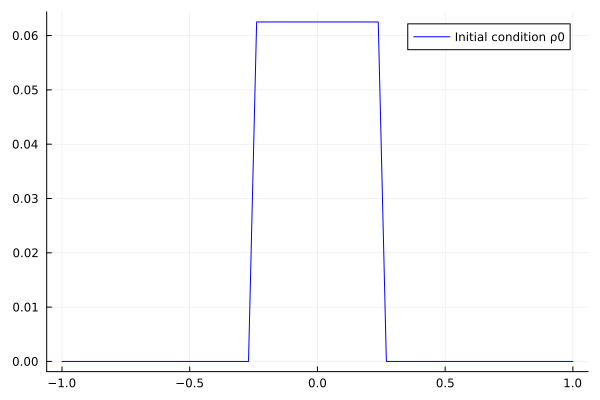

In [7]:
H(x) = x > 0
ρ0 = @. H(support + 0.25) - H(support - 0.25)
ρ0 = ρ0 / sum(ρ0)
plot(support, ρ0; label="Initial condition ρ0", color="blue")

`G_fpe` is the objective function for the implicit step scheme
$$
G_\mathrm{fpe}(\rho) = \operatorname{OT}_\varepsilon(\rho_{t}, \rho) + \tau F(\rho),
$$
and we seek to minimise in $\rho$.

In [8]:
function G_fpe(ρ, ρ0, τ, ε, C)
    return sinkhorn2(ρ, ρ0, C, ε; regularization=true, maxiter=250) + τ * (dot(Ψ, ρ) + E(ρ))
end;

`step` solves the implicit step problem to produce $\rho_{t + \tau}$ from $\rho_t$.

In [9]:
function step(ρ0, τ, ε, C, G)
    # only print error messages
    obj = u -> G(softmax(u), ρ0, τ, ε, C)
    opt = with_logger(SimpleLogger(stderr, Logging.Error)) do
        optimize(
            obj,
            ones(size(ρ0)),
            LBFGS(),
            Optim.Options(; iterations=50, g_tol=1e-6);
            autodiff=:forward,
        )
    end
    return softmax(Optim.minimizer(opt))
end

step (generic function with 1 method)

Now we simulate `N = 10` iterates of the gradient flow and plot the result.

[ Info: 2
[ Info: 3
[ Info: 4
[ Info: 5
[ Info: 6
[ Info: 7
[ Info: 8
[ Info: 9
[ Info: 10


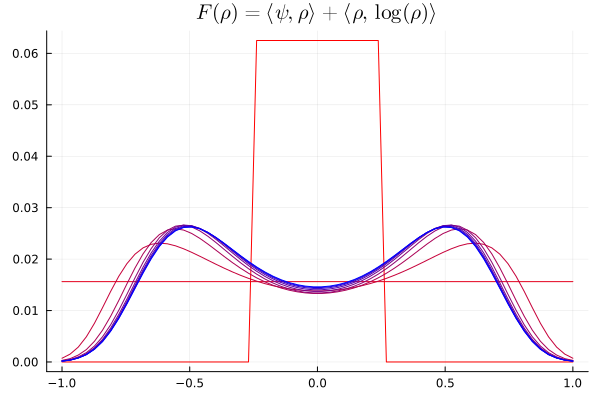

In [10]:
N = 10
ρ = similar(ρ0, size(ρ0, 1), N)
ρ[:, 1] = ρ0
for i in 2:N
    @info i
    ρ[:, i] = step(ρ[:, i - 1], τ, ε, C, G_fpe)
end
colors = range(colorant"red"; stop=colorant"blue", length=N)
plot(
    support,
    ρ;
    title=raw"$F(\rho) = \langle \psi, \rho \rangle + \langle \rho, \log(\rho) \rangle$",
    palette=colors,
    legend=nothing,
)

## Porous medium equation

The porous medium equation (PME) is the nonlinear PDE
$$
\partial_t \rho = \nabla \cdot (\rho \nabla \Psi) + \Delta \rho^m,
$$
again with Neumann boundary conditions. The value of $m$ in the PME corresponds to picking $m$ in the generalised entropy functional.
Now, we will solve the PME with $m = 2$ as a Wasserstein gradient flow.

In [11]:
function G_pme(ρ, ρ0, τ, ε, C)
    return sinkhorn2(ρ, ρ0, C, ε; regularization=true, maxiter=250) +
           τ * (dot(Ψ, ρ) + E(ρ; m=2))
end;

set up as previously

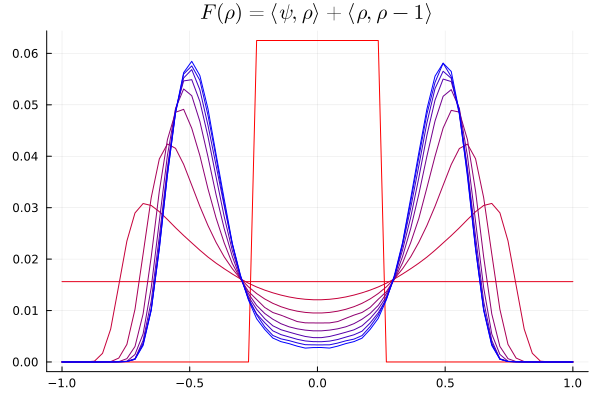

In [12]:
N = 10
ρ = similar(ρ0, size(ρ0, 1), N)
ρ[:, 1] = ρ0
for i in 2:N
    ρ[:, i] = step(ρ[:, i - 1], τ, ε, C, G_pme)
end
plot(
    support,
    ρ;
    title=raw"$F(\rho) = \langle \psi, \rho \rangle + \langle \rho, \rho - 1\rangle$",
    palette=colors,
    legend=nothing,
)

## Exploiting duality

The previous examples solved the minimisation problem for the implicit gradient flow step directly, involving automatic differentiation through the Sinkhorn iterations used to compute $\operatorname{OT}_\varepsilon(\rho_t, \rho)$ each time a gradient needs to be evaluated.
While this is straightforward to implement, it is computationally costly.
An alternative approach for convex variational problems is to proceed via the [dual problem](https://en.wikipedia.org/wiki/Duality_(optimization)).
The benefit of proceeding via the dual problem is that the part of the dual minimisation problem corresponding to the (entropy-regularised) optimal transport loss is typically available in closed form. This is in contrast to the primal problem, where evaluation of the objective and its gradients requires potentially many Sinkhorn iterations.

Consider a general convex and unconstrained problem. Under (usually satisfied) conditions for strong duality to hold, we have
$$
\begin{aligned}
&\min_{\rho} \operatorname{OT}_{\varepsilon}(\rho_0, \rho) + \mathcal{F}(\rho)  \\
&= \min_{\rho} \sup_{u}\left[\langle \rho, u \rangle - \operatorname{OT}^*_{\varepsilon}(\rho_0, u)\right] + \mathcal{F}(\rho)  \\
&= \sup_{u} \min_{\rho} \langle \rho, u \rangle - \operatorname{OT}^*_{\varepsilon}(\rho_0, u) + \mathcal{F}(\rho) \\
&= \sup_{u} - \operatorname{OT}^*_{\varepsilon}(\rho_0, u) + \min_{\rho} \langle \rho, u \rangle + \mathcal{F}(\rho) \\
&= \sup_{u} - \operatorname{OT}^*_{\varepsilon}(\rho_0, u) - \sup_{\rho} \langle \rho, -u \rangle - \mathcal{F}(\rho) \\
&= \sup_{u} - \operatorname{OT}^*_{\varepsilon}(\rho_0, u) - \mathcal{F}^*(-u).
\end{aligned}
$$
Thus, the dual problem is
$$
\min_{u} \operatorname{OT}^*_{\varepsilon}(\rho_0, u) + \mathcal{F}^*(-u).
$$

The upshot here is that $u \mapsto \operatorname{OT}^*_{\varepsilon}(\rho_0, u)$ and its gradient is available in closed form. This is a known result in the literature [^CP18].

[^CP18]: Cuturi, Marco, and Gabriel Peyré. “Semi-Dual Regularized Optimal Transport.” ArXiv: Learning, 2018.

The formulas we state below are lifted from statements in [^Z21].

[^Z21]: Zhang, Stephen Y. “A Unified Framework for Non-Negative Matrix and Tensor Factorisations with a Smoothed Wasserstein Loss.” ArXiv: Machine Learning, 2021.

$$
\begin{aligned}
\operatorname{OT}^*_{\varepsilon}(\rho_0, u) &= -\varepsilon \left\langle \rho_0, \log\left( \dfrac{\rho_0}{K e^{u/\varepsilon}} \right) - 1\right\rangle, \\
\nabla_u \operatorname{OT}^*_{\varepsilon}(\rho_0, u) &= K^\top \left( \dfrac{\rho_0}{K e^{u/\varepsilon}} \right) \odot e^{u/\varepsilon}.
\end{aligned}
$$
At optimality, we can recover the primal optimal point $\rho^\star$ from the dual optimal point $u^\star$ following the formula
$$
\rho^\star = e^{u^\star/\varepsilon} \odot K^\top \dfrac{\rho_0}{K e^{u^\star/\varepsilon}}.
$$

When $\mathcal{F}^*(\cdot)$ is also available in closed form (this is not always the case), the dual problem has a closed form objective and can generally be solved much more efficiently than the primal problem.

In the setting of the Fokker-Planck and porous medium equations, the function $\mathcal{F}$ can be identified with

$$
\mathcal{F}(\rho) = \tau \left[ \langle \psi, \rho \rangle + E_m(\rho) \right].
$$

A straightforward computation shows that
$$
\mathcal{F}^*(u) = \tau E_m^*\left( \frac{u}{\tau}-\psi \right),
$$
where
$$
    E_m^*(u) = \begin{cases}
    \langle e^u, \mathbf{1} \rangle, & m = 1 \\
    \sum_i \left[ \left( u_i + \frac{m}{m-1} \right) \left( \frac{m-1}{m} u_i + 1 \right)^{\frac{1}{m-1}} - \frac{1}{m-1} \left( \frac{m-1}{m} u_i + 1 \right)^{\frac{m}{m-1}} \right], & m > 1.
    \end{cases}
$$
In particular, for $m = 2$ we have a simpler formula
$$
E_2^*(u) = \left\| \frac{u}{2} + 1 \right\|_2^2
$$

We now implement $E_m^*$ for $m = 1, 2$.

In [13]:
E_dual(u, m::Val{1}) = sum(exp.(u))
function E_dual(u, m::Val{2})
    return dot(u / 2 .+ 1, u / 2 .+ 1)
end;

So, the dual problem we are dealing with reads
$$
\min_{u} \operatorname{OT}^*_{\varepsilon}(\rho_0, u) + \tau E_m^*\left( \frac{-u}{\tau}-\psi \right),
$$
and we can thus set up `G_dual_fpe`, the dual objective.

In [14]:
function G_dual_fpe(u, ρ0, τ, ε, K)
    return OptimalTransport.Dual.ot_entropic_semidual(ρ0, u, ε, K) +
           τ * E_dual(-u / τ - Ψ, Val(1))
end;

Now we set up `step` as previously, except this time we need to convert from the optimal dual variable $u^\star$ to the primal variable $\rho^\star$. In the code, this is handled by `getprimal_ot_entropic_semidual`. We use `ReverseDiff` in this problem.

In [15]:
function step(ρ0, τ, ε, K, G)
    obj = u -> G(u, ρ0, τ, ε, K)
    opt = optimize(
        obj,
        (∇, u) -> ReverseDiff.gradient!(∇, obj, u),
        zeros(size(ρ0)),
        LBFGS(),
        Optim.Options(; iterations=250, g_tol=1e-6),
    )
    return OptimalTransport.Dual.getprimal_ot_entropic_semidual(
        ρ0, Optim.minimizer(opt), ε, K
    )
end;

Now we can solve the dual problem as previously, and we note that the dual formulation is solved an order of magnitude faster than the primal formulation.

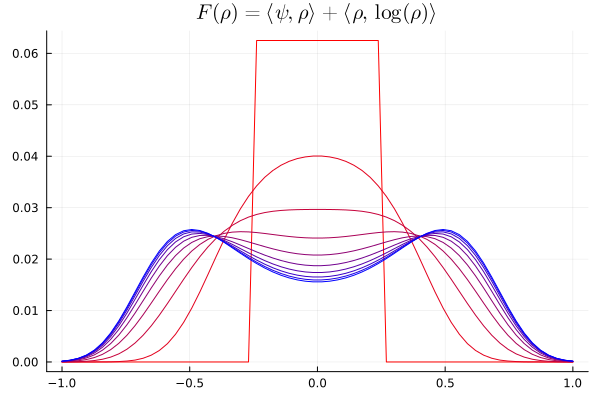

In [16]:
ρ = similar(ρ0, size(ρ0, 1), N)
ρ[:, 1] = ρ0
for i in 2:N
    ρ[:, i] = step(ρ[:, i - 1], τ, ε, K, G_dual_fpe)
end
colors = range(colorant"red"; stop=colorant"blue", length=N)
plot(
    support,
    ρ;
    title=raw"$F(\rho) = \langle \psi, \rho \rangle + \langle \rho, \log(\rho) \rangle$",
    palette=colors,
    legend=nothing,
)

Setting `m = 2`, we can simulate instead the porous medium equation.

[ Info: 2
[ Info: 3
[ Info: 4
[ Info: 5
[ Info: 6
[ Info: 7
[ Info: 8
[ Info: 9
[ Info: 10


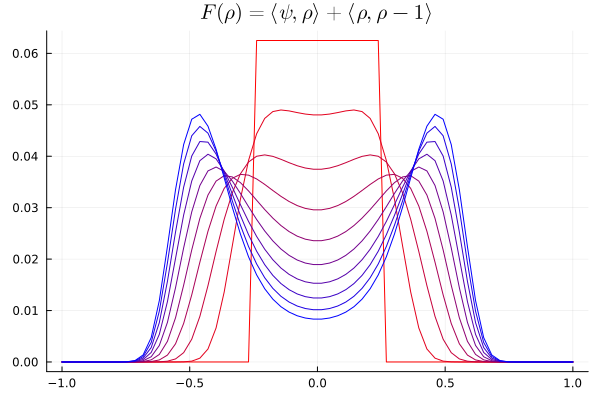

In [17]:
function G_dual_pme(u, ρ0, τ, ε, K)
    return OptimalTransport.Dual.ot_entropic_semidual(ρ0, u, ε, K) +
           τ * E_dual(-u / τ - Ψ, Val(2))
end
ρ = similar(ρ0, size(ρ0, 1), N)
ρ[:, 1] = ρ0
for i in 2:N
    @info i
    ρ[:, i] = step(ρ[:, i - 1], τ, ε, K, G_dual_pme)
end
colors = range(colorant"red"; stop=colorant"blue", length=N)
plot(
    support,
    ρ;
    title=raw"$F(\rho) = \langle \psi, \rho \rangle + \langle \rho, \rho - 1\rangle$",
    palette=colors,
    legend=nothing,
)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*